In [1]:
import tpqoa
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
api = tpqoa.tpqoa("oanda.cfg")
lm = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr") # creating LR object with predefined settings

In [59]:
df = api.get_history(instrument = "EUR_USD", start = "2016-01-01", end = "2018-12-01",
                granularity = "D", price = "B")
df.head()

,o,h,l,c,volume,complete
time,,,,,,
2016-01-03 22:00:00,1.08699,1.09456,1.07805,1.08313,41687,True
2016-01-04 22:00:00,1.08288,1.08381,1.07100,1.07470,26924,True
2016-01-05 22:00:00,1.07417,1.07984,1.07102,1.07791,37052,True
2016-01-06 22:00:00,1.07778,1.09394,1.07703,1.09291,46403,True
2016-01-07 22:00:00,1.09276,1.09323,1.08021,1.09213,56496,True


#### To calculate returns we have to create table with single value price, we will use closing price

In [60]:
data = df.copy(deep=True)

In [61]:
ret = data['c']

In [62]:
data["returns"] = np.log(ret.div(ret.shift(1)))

In [63]:
data["drawdown"] = -abs(data.o - data.l)
data["daily_gain"] = abs(data.h - data.o)
data['real'] = abs(data.c - data.o)

In [64]:
data.head()

,o,h,l,c,volume,complete,returns,drawdown,daily_gain,real
time,,,,,,,,,,
2016-01-03 22:00:00,1.08699,1.09456,1.07805,1.08313,41687,True,NaN,-0.00894,0.00757,0.00386
2016-01-04 22:00:00,1.08288,1.08381,1.07100,1.07470,26924,True,-0.007813,-0.01188,0.00093,0.00818
2016-01-05 22:00:00,1.07417,1.07984,1.07102,1.07791,37052,True,0.002982,-0.00315,0.00567,0.00374
2016-01-06 22:00:00,1.07778,1.09394,1.07703,1.09291,46403,True,0.013820,-0.00075,0.01616,0.01513
2016-01-07 22:00:00,1.09276,1.09323,1.08021,1.09213,56496,True,-0.000714,-0.01255,0.00047,0.00063


Dropna as these are not required and to prevent receving an error. Similar the complete column.

In [65]:
data.dropna(inplace=True)
data = data.drop("complete", axis=1)

In [66]:
data["direction"] = np.sign(data.returns)

In [67]:
data.head()

,o,h,l,c,volume,returns,drawdown,daily_gain,real,direction
time,,,,,,,,,,
2016-01-04 22:00:00,1.08288,1.08381,1.07100,1.07470,26924,-0.007813,-0.01188,0.00093,0.00818,-1.0
2016-01-05 22:00:00,1.07417,1.07984,1.07102,1.07791,37052,0.002982,-0.00315,0.00567,0.00374,1.0
2016-01-06 22:00:00,1.07778,1.09394,1.07703,1.09291,46403,0.013820,-0.00075,0.01616,0.01513,1.0
2016-01-07 22:00:00,1.09276,1.09323,1.08021,1.09213,56496,-0.000714,-0.01255,0.00047,0.00063,-1.0
2016-01-10 22:00:00,1.09165,1.09687,1.08467,1.08584,37850,-0.005776,-0.00698,0.00522,0.00581,-1.0


In [68]:
data.direction.value_counts()

 1.0    388
-1.0    369
Name: direction, dtype: int64

#### Define a number of lags, this will create additional features

In [69]:
lags = 5
columns = ['o', 'h', 'l', 'c', 'volume', 'returns']
cols = []
mdata = data.copy()

#### For every column in columns we would like to create a number of lagging values which is specified in variable lags.
#### Then we need to create a list containing all the cols which will be used as variables in logistic regression

In [70]:
for i in columns:
    for lag in range(1, lags + 1):
        col = "{}lag{}".format(i,lag)
        mdata[col] = mdata[i].shift(lag)
        cols.append(col)

In [71]:
cols

['olag1',
 'olag2',
 'olag3',
 'olag4',
 'olag5',
 'hlag1',
 'hlag2',
 'hlag3',
 'hlag4',
 'hlag5',
 'llag1',
 'llag2',
 'llag3',
 'llag4',
 'llag5',
 'clag1',
 'clag2',
 'clag3',
 'clag4',
 'clag5',
 'volumelag1',
 'volumelag2',
 'volumelag3',
 'volumelag4',
 'volumelag5',
 'returnslag1',
 'returnslag2',
 'returnslag3',
 'returnslag4',
 'returnslag5']

In [72]:
mdata.dropna(inplace=True)

In [73]:
mdata.head()

,o,h,l,c,volume,returns,drawdown,daily_gain,real,direction,...,volumelag1,volumelag2,volumelag3,volumelag4,volumelag5,returnslag1,returnslag2,returnslag3,returnslag4,returnslag5
time,,,,,,,,,,,,,,,,,,,,,
2016-01-11 22:00:00,1.08557,1.08998,1.08189,1.08567,28924,-0.000157,-0.00368,0.00441,0.00010,-1.0,...,37850.0,56496.0,46403.0,37052.0,26924.0,-0.005776,-0.000714,0.013820,0.002982,-0.007813
2016-01-12 22:00:00,1.08562,1.08870,1.08042,1.08759,31359,0.001767,-0.00520,0.00308,0.00197,1.0,...,28924.0,37850.0,56496.0,46403.0,37052.0,-0.000157,-0.005776,-0.000714,0.013820,0.002982
2016-01-13 22:00:00,1.08749,1.09425,1.08341,1.08642,40638,-0.001076,-0.00408,0.00676,0.00107,-1.0,...,31359.0,28924.0,37850.0,56496.0,46403.0,0.001767,-0.000157,-0.005776,-0.000714,0.013820
2016-01-14 22:00:00,1.08641,1.09840,1.08538,1.09103,47728,0.004234,-0.00103,0.01199,0.00462,1.0,...,40638.0,31359.0,28924.0,37850.0,56496.0,-0.001076,0.001767,-0.000157,-0.005776,-0.000714
2016-01-17 22:00:00,1.09183,1.09266,1.08684,1.08899,23821,-0.001872,-0.00499,0.00083,0.00284,-1.0,...,47728.0,40638.0,31359.0,28924.0,37850.0,0.004234,-0.001076,0.001767,-0.000157,-0.005776


### Fit logistic regression, use cols from mdata table to calculate direction

In [74]:
lm.fit(mdata[cols], mdata.direction)

C:\Users\Sylwia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100000, multi_class='ovr', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=0.0001,
                   verbose=0, warm_start=False)

Create column pred and use prediction from LM

In [75]:
mdata["pred"] = lm.predict(mdata[cols])

In [76]:
mdata.head()

,o,h,l,c,volume,returns,drawdown,daily_gain,real,direction,...,volumelag2,volumelag3,volumelag4,volumelag5,returnslag1,returnslag2,returnslag3,returnslag4,returnslag5,pred
time,,,,,,,,,,,,,,,,,,,,,
2016-01-11 22:00:00,1.08557,1.08998,1.08189,1.08567,28924,-0.000157,-0.00368,0.00441,0.00010,-1.0,...,56496.0,46403.0,37052.0,26924.0,-0.005776,-0.000714,0.013820,0.002982,-0.007813,1.0
2016-01-12 22:00:00,1.08562,1.08870,1.08042,1.08759,31359,0.001767,-0.00520,0.00308,0.00197,1.0,...,37850.0,56496.0,46403.0,37052.0,-0.000157,-0.005776,-0.000714,0.013820,0.002982,1.0
2016-01-13 22:00:00,1.08749,1.09425,1.08341,1.08642,40638,-0.001076,-0.00408,0.00676,0.00107,-1.0,...,28924.0,37850.0,56496.0,46403.0,0.001767,-0.000157,-0.005776,-0.000714,0.013820,1.0
2016-01-14 22:00:00,1.08641,1.09840,1.08538,1.09103,47728,0.004234,-0.00103,0.01199,0.00462,1.0,...,31359.0,28924.0,37850.0,56496.0,-0.001076,0.001767,-0.000157,-0.005776,-0.000714,1.0
2016-01-17 22:00:00,1.09183,1.09266,1.08684,1.08899,23821,-0.001872,-0.00499,0.00083,0.00284,-1.0,...,40638.0,31359.0,28924.0,37850.0,0.004234,-0.001076,0.001767,-0.000157,-0.005776,1.0


In [77]:
mdata.pred.value_counts() #our prediction

 1.0    585
-1.0    167
Name: pred, dtype: int64

In [78]:
mdata.direction.value_counts() #real values

 1.0    386
-1.0    366
Name: direction, dtype: int64

#### Calculate hits ratio

In [79]:
hits = np.sign(mdata.direction * mdata.pred).value_counts()

In [80]:
hit_ratio = hits[1.0] / sum(hits)
hit_ratio

0.5279255319148937

Simply calculate outcome of the strategy

In [81]:
mdata["strategy"] = mdata.pred * mdata.returns

In [82]:
mdata["creturns"] = mdata["returns"].cumsum().apply(np.exp)
mdata["cstrategy"] = mdata["strategy"].cumsum().apply(np.exp)

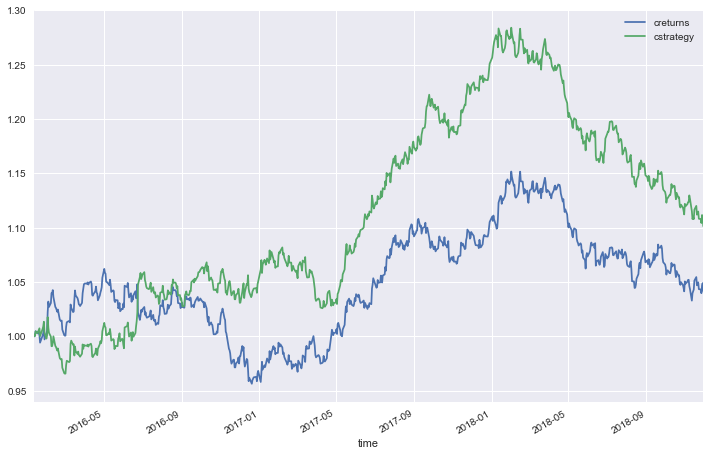

In [83]:
mdata[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

In [84]:
mdata

,o,h,l,c,volume,returns,drawdown,daily_gain,real,direction,...,volumelag5,returnslag1,returnslag2,returnslag3,returnslag4,returnslag5,pred,strategy,creturns,cstrategy
time,,,,,,,,,,,,,,,,,,,,,
2016-01-11 22:00:00,1.08557,1.08998,1.08189,1.08567,28924,-0.000157,-0.00368,0.00441,0.00010,-1.0,...,26924.0,-0.005776,-0.000714,0.013820,0.002982,-0.007813,1.0,-0.000157,0.999843,0.999843
2016-01-12 22:00:00,1.08562,1.08870,1.08042,1.08759,31359,0.001767,-0.00520,0.00308,0.00197,1.0,...,37052.0,-0.000157,-0.005776,-0.000714,0.013820,0.002982,1.0,0.001767,1.001612,1.001612
2016-01-13 22:00:00,1.08749,1.09425,1.08341,1.08642,40638,-0.001076,-0.00408,0.00676,0.00107,-1.0,...,46403.0,0.001767,-0.000157,-0.005776,-0.000714,0.013820,1.0,-0.001076,1.000534,1.000534
2016-01-14 22:00:00,1.08641,1.09840,1.08538,1.09103,47728,0.004234,-0.00103,0.01199,0.00462,1.0,...,56496.0,-0.001076,0.001767,-0.000157,-0.005776,-0.000714,1.0,0.004234,1.004780,1.004780
2016-01-17 22:00:00,1.09183,1.09266,1.08684,1.08899,23821,-0.001872,-0.00499,0.00083,0.00284,-1.0,...,37850.0,0.004234,-0.001076,0.001767,-0.000157,-0.005776,1.0,-0.001872,1.002901,1.002901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-25 22:00:00,1.13356,1.13828,1.13243,1.13268,44249,-0.000362,-0.00113,0.00472,0.00088,-1.0,...,42887.0,-0.005948,0.001282,0.001319,-0.007230,0.003096,1.0,-0.000362,1.043137,1.107860
2018-11-26 22:00:00,1.13251,1.13434,1.12767,1.12902,54367,-0.003237,-0.00484,0.00183,0.00349,-1.0,...,53042.0,-0.000362,-0.005948,0.001282,0.001319,-0.007230,1.0,-0.003237,1.039766,1.104280
2018-11-27 22:00:00,1.12860,1.13871,1.12668,1.13658,62236,0.006674,-0.00192,0.01011,0.00798,1.0,...,49349.0,-0.003237,-0.000362,-0.005948,0.001282,0.001319,1.0,0.006674,1.046729,1.111675


#### Dorzucić:
##### Opłaty transakcyjne. Godziny tradingu. Tylko pozycje long i short, bez neutral.
##### Daily Drowdown.
##### Możliwość ustawienia SL i TP. True range?
##### Zrobić backtester strategii w OOP

## Test set

In [85]:
df2 = api.get_history(instrument = "EUR_USD", start = "2019-01-01", end = "2019-12-01",
                granularity = "D", price = "B")
df2.head()

,o,h,l,c,volume,complete
time,,,,,,
2019-01-01 22:00:00,1.14603,1.14962,1.13243,1.13430,35508,True
2019-01-02 22:00:00,1.13388,1.14104,1.13051,1.13922,54135,True
2019-01-03 22:00:00,1.13914,1.14184,1.13449,1.13912,41022,True
2019-01-06 22:00:00,1.13937,1.14820,1.13935,1.14739,25648,True
2019-01-07 22:00:00,1.14728,1.14840,1.14208,1.14395,25474,True


In [86]:
ret = df2['c']
df2["returns"] = np.log(ret.div(ret.shift(1)))
df2.dropna(inplace=True)
df2 = df2.drop("complete", axis=1)
df2["direction"] = np.sign(df2.returns)

In [87]:
df2.head()

,o,h,l,c,volume,returns,direction
time,,,,,,,
2019-01-02 22:00:00,1.13388,1.14104,1.13051,1.13922,54135,0.004328,1.0
2019-01-03 22:00:00,1.13914,1.14184,1.13449,1.13912,41022,-0.000088,-1.0
2019-01-06 22:00:00,1.13937,1.14820,1.13935,1.14739,25648,0.007234,1.0
2019-01-07 22:00:00,1.14728,1.14840,1.14208,1.14395,25474,-0.003003,-1.0
2019-01-08 22:00:00,1.14395,1.15545,1.14320,1.15415,39158,0.008877,1.0


In [88]:
lags = 5
columns = ['o', 'h', 'l', 'c', 'volume', 'returns']
cols = []
for i in columns:
    for lag in range(1, lags + 1):
        col = "{}lag{}".format(i,lag)
        df2[col] = df2[i].shift(lag)
        cols.append(col)
df2.dropna(inplace = True)

In [89]:
df2.head()

,o,h,l,c,volume,returns,direction,olag1,olag2,olag3,...,volumelag1,volumelag2,volumelag3,volumelag4,volumelag5,returnslag1,returnslag2,returnslag3,returnslag4,returnslag5
time,,,,,,,,,,,,,,,,,,,,,
2019-01-09 22:00:00,1.15404,1.15694,1.14839,1.14993,32717,-0.003663,-1.0,1.14395,1.14728,1.13937,...,39158.0,25474.0,25648.0,41022.0,54135.0,0.008877,-0.003003,0.007234,-0.000088,0.004328
2019-01-10 22:00:00,1.14984,1.15399,1.14575,1.14637,31499,-0.003101,-1.0,1.15404,1.14395,1.14728,...,32717.0,39158.0,25474.0,25648.0,41022.0,-0.003663,0.008877,-0.003003,0.007234,-0.000088
2019-01-13 22:00:00,1.14559,1.14814,1.14501,1.14670,25568,0.000288,1.0,1.14984,1.15404,1.14395,...,31499.0,32717.0,39158.0,25474.0,25648.0,-0.003101,-0.003663,0.008877,-0.003003,0.007234
2019-01-14 22:00:00,1.14670,1.14891,1.13812,1.14111,37543,-0.004887,-1.0,1.14559,1.14984,1.15404,...,25568.0,31499.0,32717.0,39158.0,25474.0,0.000288,-0.003101,-0.003663,0.008877,-0.003003
2019-01-15 22:00:00,1.14103,1.14241,1.13768,1.13896,25310,-0.001886,-1.0,1.14670,1.14559,1.14984,...,37543.0,25568.0,31499.0,32717.0,39158.0,-0.004887,0.000288,-0.003101,-0.003663,0.008877


In [90]:
df2["pred"] = lm.predict(df2[cols])

In [91]:
df2.head()

,o,h,l,c,volume,returns,direction,olag1,olag2,olag3,...,volumelag2,volumelag3,volumelag4,volumelag5,returnslag1,returnslag2,returnslag3,returnslag4,returnslag5,pred
time,,,,,,,,,,,,,,,,,,,,,
2019-01-09 22:00:00,1.15404,1.15694,1.14839,1.14993,32717,-0.003663,-1.0,1.14395,1.14728,1.13937,...,25474.0,25648.0,41022.0,54135.0,0.008877,-0.003003,0.007234,-0.000088,0.004328,1.0
2019-01-10 22:00:00,1.14984,1.15399,1.14575,1.14637,31499,-0.003101,-1.0,1.15404,1.14395,1.14728,...,39158.0,25474.0,25648.0,41022.0,-0.003663,0.008877,-0.003003,0.007234,-0.000088,1.0
2019-01-13 22:00:00,1.14559,1.14814,1.14501,1.14670,25568,0.000288,1.0,1.14984,1.15404,1.14395,...,32717.0,39158.0,25474.0,25648.0,-0.003101,-0.003663,0.008877,-0.003003,0.007234,1.0
2019-01-14 22:00:00,1.14670,1.14891,1.13812,1.14111,37543,-0.004887,-1.0,1.14559,1.14984,1.15404,...,31499.0,32717.0,39158.0,25474.0,0.000288,-0.003101,-0.003663,0.008877,-0.003003,1.0
2019-01-15 22:00:00,1.14103,1.14241,1.13768,1.13896,25310,-0.001886,-1.0,1.14670,1.14559,1.14984,...,25568.0,31499.0,32717.0,39158.0,-0.004887,0.000288,-0.003101,-0.003663,0.008877,1.0


In [92]:
hits = np.sign(df2.direction * df2.pred).value_counts()
hits

-1.0    132
 1.0    100
 0.0      1
dtype: int64

In [93]:
hit_ratio = hits[1.0] / sum(hits)
hit_ratio

0.4291845493562232

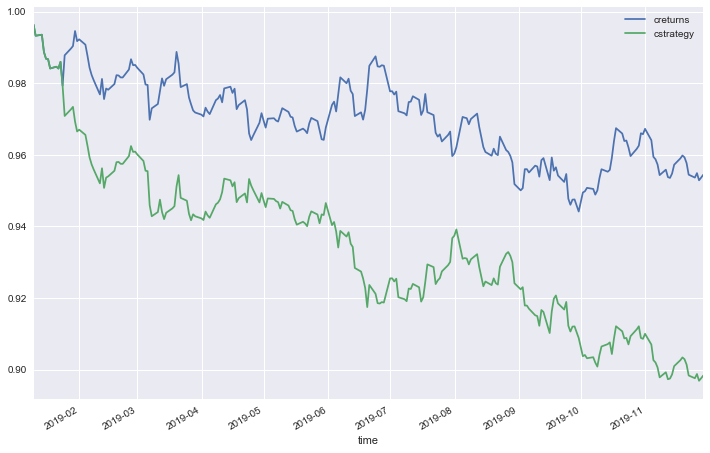

In [94]:
df2["strategy"] = df2.pred * df2.returns
df2["creturns"] = df2["returns"].cumsum().apply(np.exp)
df2["cstrategy"] = df2["strategy"].cumsum().apply(np.exp)
df2[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

In [95]:
df2["trades"] = df2.pred.diff().fillna(0).abs()
df2.trades.value_counts()

0.0    149
2.0     84
Name: trades, dtype: int64